## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import scipy.stats as st

import re
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import sklearn.preprocessing as pre
import requests as req
import seaborn as sns

import model

In [2]:
flights_1 = pd.read_csv('data/flights_1%.csv')
fuel_consumption = pd.read_csv('data/fuel_consumption.csv')
passengers_10 = pd.read_csv('data/passengers_10%.csv')
test = pd.read_csv('data/test.csv')
pd.set_option('display.max_columns', None)

In [3]:
flights = pd.read_csv('data/flights_1%.csv')

In [4]:
flights_1.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [5]:
flights_1.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-12-19,WN,WN,WN,493,WN,N421LV,493,13342,MKE,"Milwaukee, WI",13204,MCO,"Orlando, FL",1140,1146.0,6.0,9.0,1155.0,1513.0,6.0,1515,1519.0,4.0,0,NaN,0,N,155,153.0,138.0,1,1066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-12-19,WN,WN,WN,51,WN,N7719A,51,13495,MSY,"New Orleans, LA",11259,DAL,"Dallas, TX",1655,1655.0,0.0,10.0,1705.0,1816.0,7.0,1820,1823.0,3.0,0,NaN,0,N,85,88.0,71.0,1,436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-19,WN,WN,WN,2398,WN,N724SW,2398,13495,MSY,"New Orleans, LA",12191,HOU,"Houston, TX",610,620.0,10.0,12.0,632.0,725.0,3.0,730,728.0,-2.0,0,NaN,0,N,80,68.0,53.0,1,302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-12-19,WN,WN,WN,943,WN,N8685B,943,13796,OAK,"Oakland, CA",12889,LAS,"Las Vegas, NV",1745,1745.0,0.0,13.0,1758.0,1901.0,5.0,1910,1906.0,-4.0,0,NaN,0,N,85,81.0,63.0,1,407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-19,WN,WN,WN,2443,WN,N8698B,2443,13851,OKC,"Oklahoma City, OK",11292,DEN,"Denver, CO",600,558.0,-2.0,8.0,606.0,618.0,6.0,645,624.0,-21.0,0,NaN,0,N,105,86.0,72.0,1,495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
flights_1.describe()

,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
count,159961.000000,159961.000000,159961.000000,159961.000000,159961.000000,157456.000000,157396.000000,157305.000000,157307.000000,157242.000000,157240.000000,159961.000000,157304.000000,156904.000000,159961.000000,159961.000000,159961.000000,156938.000000,156876.000000,159961.0,159961.000000,30006.000000,30006.000000,30006.000000,30006.000000,30006.000000,1063.000000,1063.000000,1063.000000,0.0
mean,2733.833941,2733.827927,12691.153250,12673.365914,1328.890548,1334.127718,10.518565,17.498141,1358.618059,1459.692194,7.687770,1483.098993,1464.231081,5.444909,0.016310,0.002588,137.932859,133.154144,108.025683,1.0,768.983834,20.636273,4.141072,16.071652,0.091415,27.027528,1344.516463,41.082785,40.466604,NaN
std,1864.051970,1864.214715,1522.691443,1521.415464,489.678493,503.086656,48.676050,9.969041,504.562665,532.107638,6.195948,516.991582,536.355568,50.775570,0.126666,0.050808,71.428902,71.489945,69.542472,0.0,584.696281,65.467117,35.200001,36.628748,2.582176,54.173376,506.650477,36.028926,34.924273,NaN
min,1.000000,1.000000,10135.000000,10135.000000,1.000000,1.000000,-47.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,-69.000000,0.000000,0.000000,18.000000,14.000000,8.000000,1.0,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,1.000000,NaN
25%,1121.000000,1121.000000,11292.000000,11292.000000,915.000000,918.000000,-6.000000,11.000000,933.000000,1044.000000,4.000000,1100.000000,1048.000000,-15.000000,0.000000,0.000000,87.000000,82.000000,58.000000,1.0,341.000000,0.000000,0.000000,0.000000,0.000000,0.000000,859.000000,17.000000,17.000000,NaN
50%,2317.000000,2317.000000,12889.000000,12889.000000,1320.000000,1326.000000,-2.000000,15.000000,1340.000000,1500.000000,6.000000,1511.000000,1503.000000,-6.000000,0.000000,0.000000,119.000000,115.000000,89.000000,1.0,604.000000,0.000000,0.000000,3.000000,0.000000,3.000000,1401.000000,30.000000,30.000000,NaN
75%,4325.000000,4325.000000,14057.000000,14057.000000,1735.000000,1743.000000,6.000000,20.000000,1759.000000,1908.000000,9.000000,1915.000000,1913.000000,8.000000,0.000000,0.000000,168.000000,163.000000,137.000000,1.0,1005.000000,17.000000,0.000000,20.000000,0.000000,33.000000,1737.500000,52.000000,51.000000,NaN
max,9391.000000,9391.000000,16869.000000,16869.000000,2359.000000,2400.000000,1671.000000,170.000000,2400.000000,2400.000000,193.000000,2359.000000,2400.000000,1648.000000,1.000000,1.000000,695.000000,685.000000,650.000000,1.0,5095.000000,1484.000000,1236.000000,1243.000000,205.000000,1648.000000,2349.000000,229.000000,229.000000,NaN


#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [7]:
delay = flights_1.arr_delay#.sample(5000)

In [8]:
delay.isnull().sum()

3057

In [9]:
delay_nona = delay.dropna()

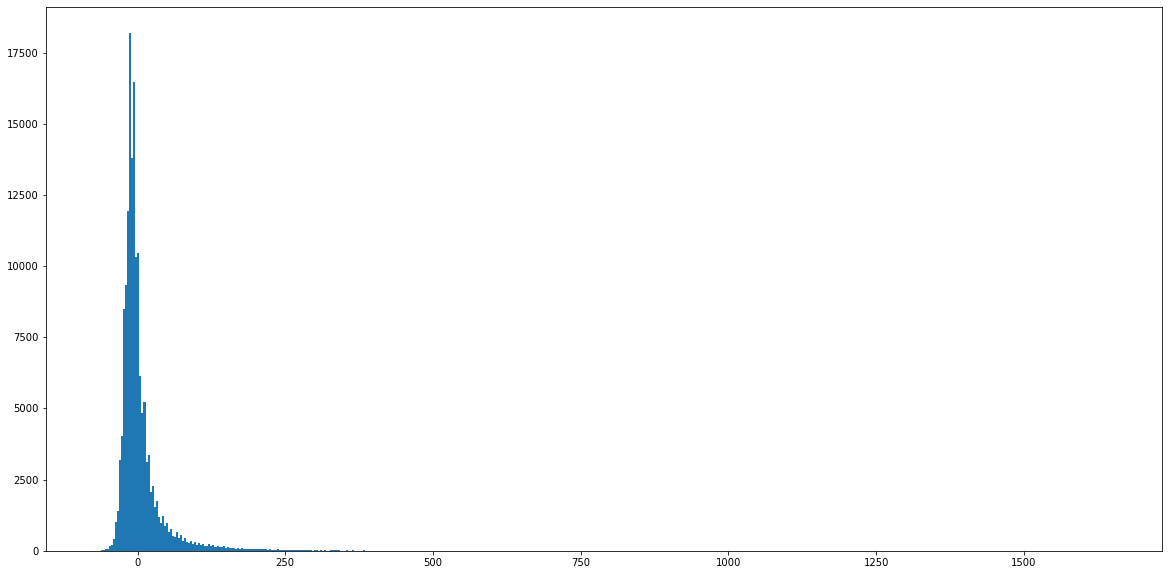

In [10]:
plt.figure(figsize=(20,10))
plt.hist(delay_nona, bins = 500)
plt.show()

In [11]:
# yj = pre.PowerTransformer()
# yj.fit(delay_nona.values.reshape(-1, 1))
# model.save(yj, 'y_normalizer')

In [155]:
delay_yj = model.load('y_normalizer').transform(delay_nona.values.reshape(-1, 1))

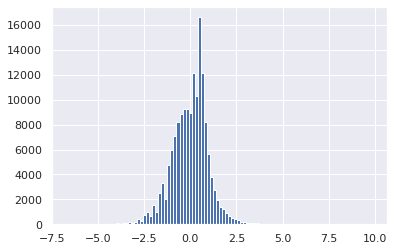

In [156]:
plt.hist(delay_yj, bins = 100)
plt.show()

In [13]:
delay_sample = delay_nona.sample(5000)

In [151]:
 st.shapiro(delay_sample).pvalue

0.0

In [16]:
delay_yj.mean()

-6.602580614504577e-17

In [18]:
np.median(delay_yj)

0.08269698071442079

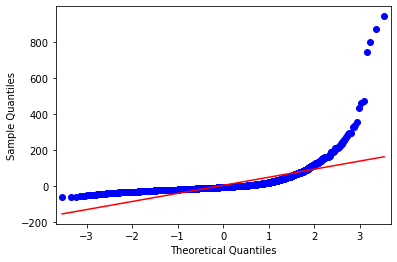

In [14]:



qqplot(delay_sample, line='s')
pyplot.show()

In [15]:
conf_int = st.norm.interval(0.68, loc=delay_sample.mean(), 
    scale=delay_sample.std())

In [16]:
delay_sample.mean()

4.3878

In [17]:
delay_sample.std()

44.759120712290446

In [18]:
conf_int

(-40.12326043787417, 48.89886043787419)

In [19]:
delay_2 = delay_sample[delay_sample<delay.std()*3]

In [20]:
delay_2.std()

27.49110201554187

In [21]:
delay_2.mean()

0.8040170419963482

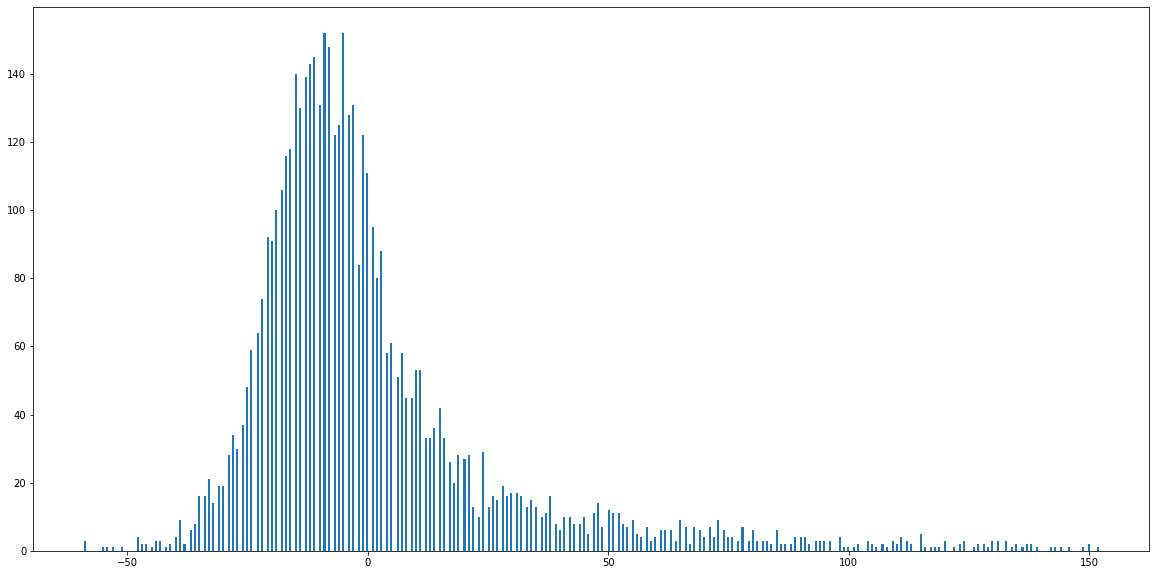

In [22]:
plt.figure(figsize=(20,10))
plt.hist(delay_2, bins = 500)
plt.show()

In [23]:
 st.shapiro(delay_2).pvalue

0.0

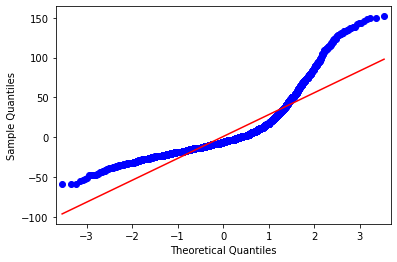

In [24]:
qqplot(delay_2, line='s')
pyplot.show()

In [25]:
st.lognorm.fit(delay_2)

(0.3545685484262389, -64.87515929216758, 61.38357320458638)

In [26]:
#stats.kstest(delay_2, 'lognorm')
st.kstest(delay_2, 'lognorm',st.lognorm.fit(delay_2))


KstestResult(statistic=0.10293505163754924, pvalue=6.353055277852776e-46)

In [27]:
st.lognorm.fit(delay_sample)

(0.41084076470959696, -63.21417483422806, 60.92188184915679)

In [28]:
st.kstest(delay_2, 'lognorm',st.lognorm.fit(delay_sample))


KstestResult(statistic=0.13420780660978593, pvalue=6.928121307964089e-78)

In [29]:
st.normaltest(delay_sample).pvalue

0.0

In [30]:
st.normaltest(delay_2).pvalue

0.0

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [31]:
flights_1_copy = flights_1.copy()

In [32]:
flights_1_copy['month']=flights_1_copy.fl_date

In [33]:
flights_1_copy.month = flights_1_copy.month.map(lambda v: int(v[5:7]))


In [34]:
month_v_delays = flights_1_copy[['month','arr_delay']]

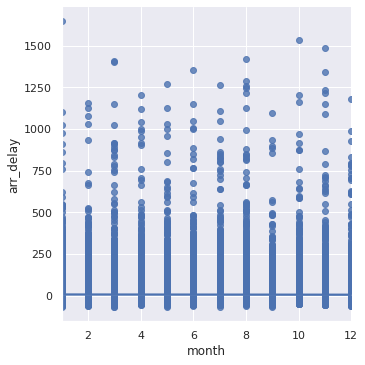

In [35]:
sns.set_theme(color_codes=True)

g = sns.lmplot(x="month", y="arr_delay", data=month_v_delays)

In [36]:
flights_1_copy_month1 = flights_1_copy[flights_1_copy.month==1].arr_delay.dropna()
flights_1_copy_month2 = flights_1_copy[flights_1_copy.month==2].arr_delay.dropna()
flights_1_copy_month3 = flights_1_copy[flights_1_copy.month==3].arr_delay.dropna()
flights_1_copy_month4 = flights_1_copy[flights_1_copy.month==4].arr_delay.dropna()
flights_1_copy_month5 = flights_1_copy[flights_1_copy.month==5].arr_delay.dropna()
flights_1_copy_month6 = flights_1_copy[flights_1_copy.month==6].arr_delay.dropna()
flights_1_copy_month7 = flights_1_copy[flights_1_copy.month==7].arr_delay.dropna()
flights_1_copy_month8 = flights_1_copy[flights_1_copy.month==8].arr_delay.dropna()
flights_1_copy_month9 = flights_1_copy[flights_1_copy.month==9].arr_delay.dropna()
flights_1_copy_month10 = flights_1_copy[flights_1_copy.month==10].arr_delay.dropna()
flights_1_copy_month11 = flights_1_copy[flights_1_copy.month==11].arr_delay.dropna()
flights_1_copy_month12 = flights_1_copy[flights_1_copy.month==12].arr_delay.dropna()


In [37]:
st.f_oneway(flights_1_copy_month1,
             flights_1_copy_month2,
             flights_1_copy_month3,
             flights_1_copy_month4,
             flights_1_copy_month5,
             flights_1_copy_month6,
             flights_1_copy_month7,
             flights_1_copy_month8,
             flights_1_copy_month9,
             flights_1_copy_month10,
             flights_1_copy_month11,
             flights_1_copy_month12).pvalue

1.3124775867467312e-90

In [38]:
print('Mean of Jan: ',flights_1_copy_month1.mean(),'\n',
             'Mean of Feb: ',flights_1_copy_month2.mean(),'\n',
             'Mean of Mar: ',flights_1_copy_month3.mean(),'\n',
             'Mean of Apr: ',flights_1_copy_month4.mean(),'\n',
             'Mean of May: ',flights_1_copy_month5.mean(),'\n',
             'Mean of Jun: ',flights_1_copy_month6.mean(),'\n',
             'Mean of Jul: ',flights_1_copy_month7.mean(),'\n',
             'Mean of Aug: ',flights_1_copy_month8.mean(),'\n',
             'Mean of Sep: ',flights_1_copy_month9.mean(),'\n',
             'Mean of Oct: ',flights_1_copy_month10.mean(),'\n',
             'Mean of Nov: ',flights_1_copy_month11.mean(),'\n',
             'Mean of Dec: ',flights_1_copy_month12.mean(),'\n',
             '\n')
print('Std of Jan: ',flights_1_copy_month1.std(),'\n',
             'Std of Feb: ',flights_1_copy_month2.std(),'\n',
             'Std of Mar: ',flights_1_copy_month3.std(),'\n',
             'Std of Apr: ',flights_1_copy_month4.std(),'\n',
             'Std of May: ',flights_1_copy_month5.std(),'\n',
             'Std of Jun: ',flights_1_copy_month6.std(),'\n',
             'Std of Jul: ',flights_1_copy_month7.std(),'\n',
             'Std of Aug: ',flights_1_copy_month8.std(),'\n',
             'Std of Sep: ',flights_1_copy_month9.std(),'\n',
             'Std of Oct: ',flights_1_copy_month10.std(),'\n',
             'Std of Nov: ',flights_1_copy_month11.std(),'\n',
             'Std of Dec: ',flights_1_copy_month12.std())

Mean of Jan:  4.045409592879512 
 Mean of Feb:  5.850384441429218 
 Mean of Mar:  3.911124501016796 
 Mean of Apr:  4.774859144205878 
 Mean of May:  6.772097575666315 
 Mean of Jun:  9.561670109176749 
 Mean of Jul:  8.600245735761781 
 Mean of Aug:  9.695371367061357 
 Mean of Sep:  0.441340349791054 
 Mean of Oct:  2.992882823391298 
 Mean of Nov:  3.4523443504996156 
 Mean of Dec:  4.633241967412822 
 

Std of Jan:  51.23429131824932 
 Std of Feb:  49.99592034728437 
 Std of Mar:  51.75449695170123 
 Std of Apr:  49.64515465922439 
 Std of May:  50.0818719348215 
 Std of Jun:  52.360125056800214 
 Std of Jul:  54.50448200531286 
 Std of Aug:  58.97239360384739 
 Std of Sep:  39.98932993278865 
 Std of Oct:  46.8717190884938 
 Std of Nov:  51.198629231035135 
 Std of Dec:  48.746297316414015


#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

So what kinds of numbers are we dealing with?

In [39]:
city_dates = list(
    set(flights.groupby(['origin_city_name', 'fl_date']).groups.keys()) |
    set(flights.groupby(['dest_city_name', 'fl_date']).groups.keys())
)
len(city_dates)

83424

In [40]:
flights_sample = flights.sample(2000, random_state=1234)
city_dates_sample = list(
    set(flights_sample.groupby(['origin_city_name', 'fl_date']).groups.keys()) |
    set(flights_sample.groupby(['dest_city_name', 'fl_date']).groups.keys())
)
len(city_dates_sample)

3771

In [41]:
len(
    set(test.groupby(['origin_city_name', 'fl_date']).groups.keys()) |
    set(test.groupby(['dest_city_name', 'fl_date']).groups.keys())
)

10850

In [42]:
flights.fl_date.min(), flights.fl_date.max()

('2018-01-01', '2019-12-31')

In [43]:
test.fl_date.min(), test.fl_date.max()

('2020-01-01 00:00:00', '2020-01-31 00:00:00')

Set up the Visual Crossing API call

In [44]:
def deslash(place):
    """
    Extracts only the first name in a "slashed" city name.
    
    Some cities in the flight data are for multi-city metro areas, written
    with slashes; for example, "Pasco/Kennewick/Richland, WA".
    This function pulls out only the first name so we can pass it to the
    Visual Crossing API. The example above would yield "Pasco, WA".
    """
    city, state = place.split(', ')
    city = city.split('/')[0]
    return f'{city}, {state}'

In [45]:
#import visual_crossing_env
#api_key = visual_crossing_env.API_KEY
url = (
    'https://weather.visualcrossing.com/'
    'VisualCrossingWebServices/rest/services/timeline'
)
def get_weather(place, date):
    response = req.get(
        f"{url}/{deslash(place)}/{date}",
        params=dict(
            unitGroup='us',
            key=api_key,
            include='obs',
        )
    )
    if response.status_code == 200:
        return response.json()
    else:
        print(response.status_code)

In [46]:
def get_weather_conditions(place, date):
    weather = get_weather(place, date)
    if weather is not None:
        return weather['days'][0]['conditions']

In [47]:
# Test call
# get_weather('Milwaukee, WI', '2018-01-01')
# get_weather_conditions('Milwaukee, WI', '2018-01-01')
# get_weather_conditions('Pasco/Kennewick/Richland, WA', '2018-11-10')

In [48]:
city_dates_split = np.array_split(np.array(city_dates_sample), 5)

In [49]:
def get_weather_for_splits(splits, split_idxs):
    result = []
    for split_idx in split_idxs:
        split_result = []
        for row in splits[split_idx]:
            city, date = row
            split_result.append([city, date, get_weather_conditions(city, date)])
        result.append(np.array(split_result))
    return np.vstack(result)

Uncomment to get new data:

In [50]:
# weather_0 = get_weather_for_splits(city_dates_split, [0])
# weather_0_df = pd.DataFrame(weather_0)
# weather_0_df.columns = ['city', 'date', 'conditions']
# weather_0_df.to_csv('weather_0.csv', index=False)

In [51]:
# for i in range(1, 5):
#     weather = get_weather_for_splits(city_dates_split, [i])
#     weather_df = pd.DataFrame(weather)
#     weather_df.columns = ['city', 'date', 'conditions']
#     weather_df.to_csv(f'weather_{i}.csv', index=False)

Load saved data:

In [52]:
weather_bits = [pd.read_csv(f'weather_{i}.csv') for i in range(5)]
weather = pd.concat(weather_bits)
len(weather)

3771

Analysis

In [53]:
weather.head()

,city,date,conditions
0,"Indianapolis, IN",2018-12-02,Partially cloudy
1,"San Antonio, TX",2018-05-20,"Rain, Partially cloudy"
2,"Houston, TX",2019-05-26,Partially cloudy
3,"Newark, NJ",2018-07-12,Partially cloudy
4,"Las Vegas, NV",2018-03-01,Partially cloudy


In [54]:
flights_with_weather = flights.merge(
    weather, left_on=['fl_date', 'origin_city_name'], right_on=['date', 'city']
).merge(
    weather, left_on=['fl_date', 'dest_city_name'], right_on=['date', 'city'],
    suffixes=('_origin', '_dest')
)

In [55]:
flights_with_weather.conditions_origin.value_counts()

Partially cloudy          1173
Clear                      830
Rain, Partially cloudy     755
Rain, Overcast             435
Overcast                   221
Rain                        95
Snow, Partially cloudy      77
Snow, Overcast              54
Snow                        27
Name: conditions_origin, dtype: int64

In [56]:
weather_category_map = {
    'Partially cloudy': 'Cloudy',
    'Clear': 'Sunny',
    'Rain, Partially cloudy': 'Rainy',
    'Rain, Overcast': 'Rainy',
    'Overcast': 'Cloudy',
    'Rain': 'Rainy',
    'Snow, Partially cloudy': 'Snowy',
    'Snow, Overcast': 'Snowy',
    'Snow': 'Snowy',
}

In [57]:
weather_categories = ['Sunny', 'Cloudy', 'Rainy', 'Snowy']

In [58]:
flights_with_weather['weather_origin'] = flights_with_weather.conditions_origin.map(weather_category_map)
flights_with_weather['weather_dest'] = flights_with_weather.conditions_dest.map(weather_category_map)

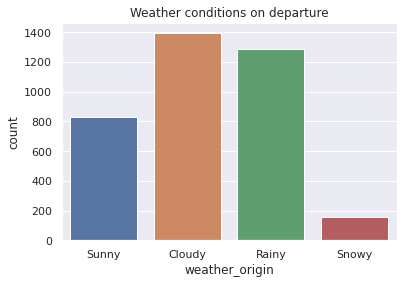

In [59]:
sns.countplot(data=flights_with_weather, x='weather_origin', order=weather_categories)
plt.title('Weather conditions on departure')
plt.show()

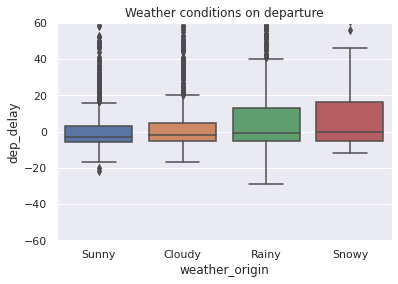

In [60]:
sns.boxplot(data=flights_with_weather, x='weather_origin', y='dep_delay', order=weather_categories)
plt.title('Weather conditions on departure')
plt.ylim(-60, 60)
plt.show()

In [61]:
def all_ranksums(conditions, delays):
    for i, condition_i in enumerate(conditions):
        for j, condition_j in enumerate(conditions):
            if j > i:
                pvalue = st.ranksums(delays[i], delays[j]).pvalue
                print(f'{condition_i} vs. {condition_j}: {pvalue}')

In [67]:
dep_delays = flights_with_weather.groupby('weather_origin').dep_delay
dep_delays = [dep_delays.groups[category] for category in weather_categories]

In [69]:
all_ranksums(weather_categories, dep_delays)

Sunny vs. Cloudy: 0.4694989831943952
Sunny vs. Rainy: 0.5077626187409153
Sunny vs. Snowy: 0.6882669239783149
Cloudy vs. Rainy: 0.11850177790238425
Cloudy vs. Snowy: 0.9970110819605214
Rainy vs. Snowy: 0.6052165856282392


Nothing is significant!

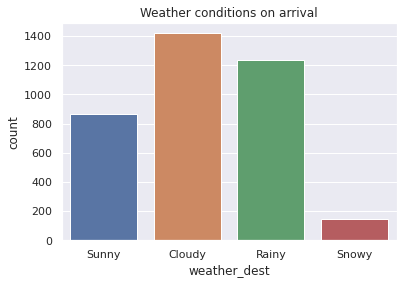

In [73]:
sns.countplot(data=flights_with_weather, x='weather_dest', order=weather_categories)
plt.title('Weather conditions on arrival')
plt.show()

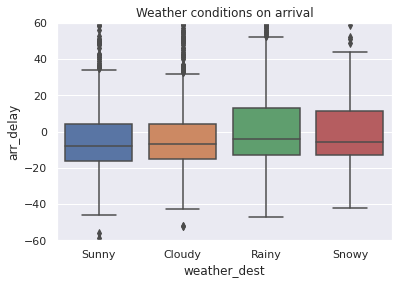

In [74]:
sns.boxplot(data=flights_with_weather, x='weather_dest', y='arr_delay', order=weather_categories)
plt.title('Weather conditions on arrival')
plt.ylim(-60, 60)
plt.show()

In [71]:
arr_delays = flights_with_weather.groupby('weather_dest').arr_delay
arr_delays = [arr_delays.groups[category] for category in weather_categories]

In [72]:
all_ranksums(weather_categories, arr_delays)

Sunny vs. Cloudy: 0.3868077354706917
Sunny vs. Rainy: 0.18002882569134204
Sunny vs. Snowy: 0.24374841699455063
Cloudy vs. Rainy: 0.012646287512659511
Cloudy vs. Snowy: 0.40112845898756133
Rainy vs. Snowy: 0.05851946060892765


Now only cloudy vs. rainy is significant.

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

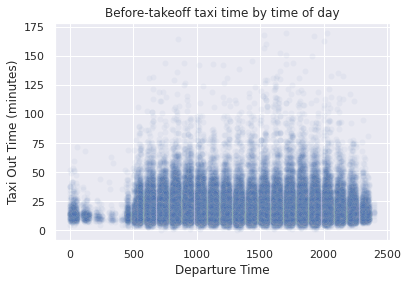

In [75]:
sns.scatterplot(data=flights, x='dep_time', y='taxi_out', alpha=0.05)
plt.xlabel('Departure Time')
plt.ylabel('Taxi Out Time (minutes)')
plt.title('Before-takeoff taxi time by time of day')
plt.show()

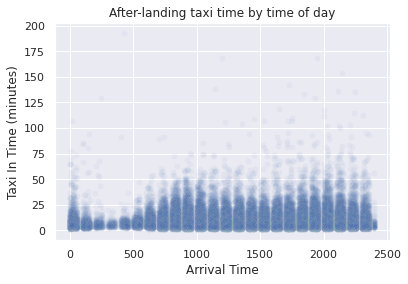

In [76]:
sns.scatterplot(data=flights, x='arr_time', y='taxi_in', alpha=0.05)
plt.xlabel('Arrival Time')
plt.ylabel('Taxi In Time (minutes)')
plt.title('After-landing taxi time by time of day')
plt.show()

In [77]:
outbound_traffic = flights.origin.value_counts().to_frame(name='flights')

In [78]:
outbound_traffic_taxi = flights[['taxi_out', 'origin']].merge(
    outbound_traffic, left_on='origin', right_index=True
)

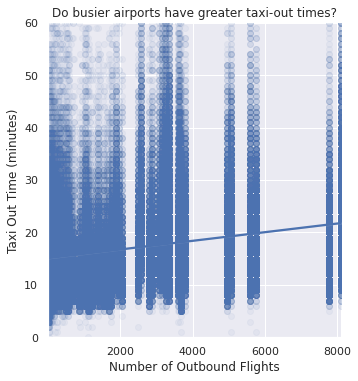

In [79]:
sns.lmplot(data=outbound_traffic_taxi, x='flights', y='taxi_out', scatter_kws=dict(alpha=0.05))
plt.ylim(0, 60)
plt.xlabel('Number of Outbound Flights')
plt.ylabel('Taxi Out Time (minutes)')
plt.title('Do busier airports have greater taxi-out times?')
plt.show()

But for actual training, it may be better to assume a logarithmic relationship

In [80]:
inbound_traffic = flights.dest.value_counts().to_frame(name='flights')

In [81]:
inbound_traffic_taxi = flights[['taxi_in', 'dest']].merge(
    outbound_traffic, left_on='dest', right_index=True
)

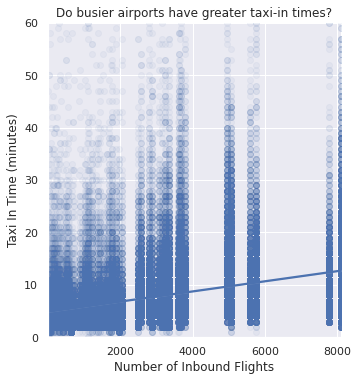

In [82]:
sns.lmplot(data=inbound_traffic_taxi, x='flights', y='taxi_in', scatter_kws=dict(alpha=0.05))
plt.ylim(0, 60)
plt.xlabel('Number of Inbound Flights')
plt.ylabel('Taxi In Time (minutes)')
plt.title('Do busier airports have greater taxi-in times?')
plt.show()

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [83]:
num_arr_delays = flights.arr_delay[flights.arr_delay > 0].count()
num_arr_delays

54832

In [84]:
num_arr_delays_with_dep_delay = flights.arr_delay[
    (flights.arr_delay > 0) & (flights.dep_delay > 0)
].count()
num_arr_delays_with_dep_delay

39112

In [85]:
num_arr_delays_with_bigger_dep_delay = flights.arr_delay[
    (flights.arr_delay > 0) & (flights.dep_delay >= flights.arr_delay)
].count()
num_arr_delays_with_bigger_dep_delay

24660

In [86]:
fr_arr_delays_with_dep_delay = num_arr_delays_with_dep_delay / num_arr_delays
f"{fr_arr_delays_with_dep_delay:.1%} of delayed arrivals also had delayed departures"

'71.3% of delayed arrivals also had delayed departures'

In [87]:
fr_arr_delays_with_bigger_dep_delay = num_arr_delays_with_bigger_dep_delay / num_arr_delays
f"{fr_arr_delays_with_bigger_dep_delay:.1%} of delayed arrivals had departure delays at least as long"

'45.0% of delayed arrivals had departure delays at least as long'

We can think of this range (45% to 71%) as bounds on the percentage of arrival delays that are caused by departure delays. At the upper bound, we're counting any departure delay as causing the arrival delay, even if there were also other causes. At the lower bound, we reason that if the departure delay isn't at least as long as the arrival delay, it can't be the only cause. This misses cases where the departure delay was still the primary cause (e.g. a 50 minute departure delay leading to a 52 minute arrival delay), but counts complicated cases where the departure was delayed, then the plane made up the lost time before being delayed again for unrelated reasons.

In [88]:
num_dep_delays = flights.dep_delay[flights.dep_delay > 0].count()
num_dep_delays

53502

In [89]:
num_dep_delays_with_smaller_arr_delay = flights.dep_delay[
    (flights.dep_delay > 0) & (flights.arr_delay <= flights.dep_delay)
].count()
num_dep_delays_with_smaller_arr_delay

38738

In [90]:
num_dep_delays_with_ontime_arr = flights.dep_delay[
    (flights.dep_delay > 0) & (flights.arr_delay <= 0)
].count()
num_dep_delays_with_ontime_arr

14078

In [91]:
fr_dep_delays_with_smaller_arr_delay = num_dep_delays_with_smaller_arr_delay / num_dep_delays
f"{fr_dep_delays_with_smaller_arr_delay:.1%} of delayed departures made up some of the time during flight"

'72.4% of delayed departures made up some of the time during flight'

In [92]:
fr_dep_delays_with_ontime_arr = num_dep_delays_with_ontime_arr / num_dep_delays
f"{fr_dep_delays_with_ontime_arr:.1%} of delayed departures arrived on time anyway"

'26.3% of delayed departures arrived on time anyway'

#### **Task 6**: How many states cover 50% of US air traffic? 

In [93]:
flights_1_copy2 = flights_1.copy()

In [94]:
flights_1_copy2['State'] = flights_1_copy2['origin_city_name'].str.extract(pat = ', (..)')


In [95]:
flights_1_copy2.State.unique()

array(['WI', 'LA', 'CA', 'OK', 'OR', 'AZ', 'TX', 'UT', 'MO', 'FL', 'NY',
       'NC', 'TN', 'PR', 'DC', 'WA', 'HI', 'SC', 'IL', 'GA', 'CO', 'PA',
       'MI', 'OH', 'AR', 'NV', 'IA', 'AL', 'VA', 'MS', 'NJ', 'MA', 'MN',
       'NM', 'IN', 'ID', 'MD', 'KY', 'MT', 'KS', 'AK', 'CT', 'ME', 'TT',
       'ND', 'NH', 'WY', 'NE', 'SD', 'VT', 'VI', 'RI', 'WV'], dtype=object)

In [96]:
len(flights_1_copy2)

159961

In [97]:
flights_1_copy2.groupby('State').mkt_carrier_fl_num.count().sort_values(ascending=False)


State
CA    17531
TX    15726
FL    11508
IL    10228
GA     8286
NY     8132
NC     7464
CO     6249
PA     4860
DC     4770
WA     4576
MI     4569
AZ     4278
NV     3822
OH     3596
MN     3458
NJ     3331
MA     3140
MO     2957
TN     2802
UT     2585
HI     2463
OR     2259
MD     2105
LA     1724
VA     1561
IN     1480
SC     1444
WI     1402
OK      922
AL      887
AK      823
KY      789
NE      696
ID      688
AR      675
NM      619
MT      615
PR      589
CT      588
IA      568
ND      450
ME      408
RI      373
KS      338
MS      336
SD      325
NH      244
VT      243
WY      199
WV      152
VI       84
TT       44
Name: mkt_carrier_fl_num, dtype: int64

In [98]:
CA = flights_1_copy2.groupby('State').mkt_carrier_fl_num.count()['CA']/len(flights_1_copy2)

In [99]:
TX = flights_1_copy2.groupby('State').mkt_carrier_fl_num.count()['TX']/len(flights_1_copy2)

In [100]:
FL = flights_1_copy2.groupby('State').mkt_carrier_fl_num.count()['FL']/len(flights_1_copy2)

In [101]:
IL = flights_1_copy2.groupby('State').mkt_carrier_fl_num.count()['IL']/len(flights_1_copy2)

In [102]:
GA = flights_1_copy2.groupby('State').mkt_carrier_fl_num.count()['GA']/len(flights_1_copy2)

In [103]:
NY = flights_1_copy2.groupby('State').mkt_carrier_fl_num.count()['NY']/len(flights_1_copy2)

In [104]:
NC = flights_1_copy2.groupby('State').mkt_carrier_fl_num.count()['NC']/len(flights_1_copy2)

In [105]:
CO = flights_1_copy2.groupby('State').mkt_carrier_fl_num.count()['CO']/len(flights_1_copy2)

In [106]:
CA + TX + FL + IL + GA + NY + NC + CO

0.5321547127112233

8 States make up 50% of the travel in the United States

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

In [107]:
flights_1_copy5 = flights_1.copy()

In [108]:
flights_1_copy5.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [109]:
flights_1_copy5['flight_speed'] = flights_1_copy5.distance
flights_1_copy5.flight_speed = flights_1_copy5.flight_speed/flights_1_copy5.air_time

In [110]:
flights_1_copy5 = flights_1_copy5.dropna(subset=['flight_speed'])

In [111]:
flights_1_copy5.flight_speed.isnull().sum()

0

In [112]:
flights_1_copy5 = flights_1_copy5.dropna(subset=['dep_delay'])

In [113]:
flights_1_copy5.dep_delay.isnull().sum()

0

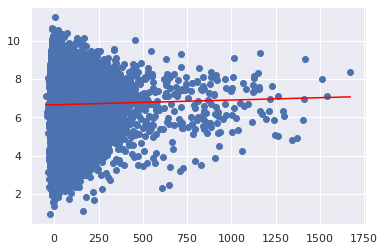

In [114]:
x = flights_1_copy5.dep_delay
y = flights_1_copy5.flight_speed

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'red')
plt.scatter(x, y)#, 'o', color='black');
#plt.plot(x, w*x, c='red')

In [115]:
correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

9.418699958209438e-05


#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [116]:
flights_1_copy3 = flights_1.copy()

In [117]:
sort_flights_1_copy3 = flights_1_copy3[flights_1_copy3.crs_elapsed_time/60<3]
medium_flights_1_copy3 = flights_1_copy3[(flights_1_copy3.crs_elapsed_time/60>=3)&(flights_1_copy3.crs_elapsed_time/60<6)]
long_flights_1_copy3 = flights_1_copy3[flights_1_copy3.crs_elapsed_time/60>=6]


In [118]:
(long_flights_1_copy3.crs_elapsed_time/60).max()

11.583333333333334

In [119]:
sort_flight_hours = round(sort_flights_1_copy3.wheels_off/100)
medium_flight_hours = round(medium_flights_1_copy3.wheels_off/100)
long_flight_hours = round(long_flights_1_copy3.wheels_off/100)

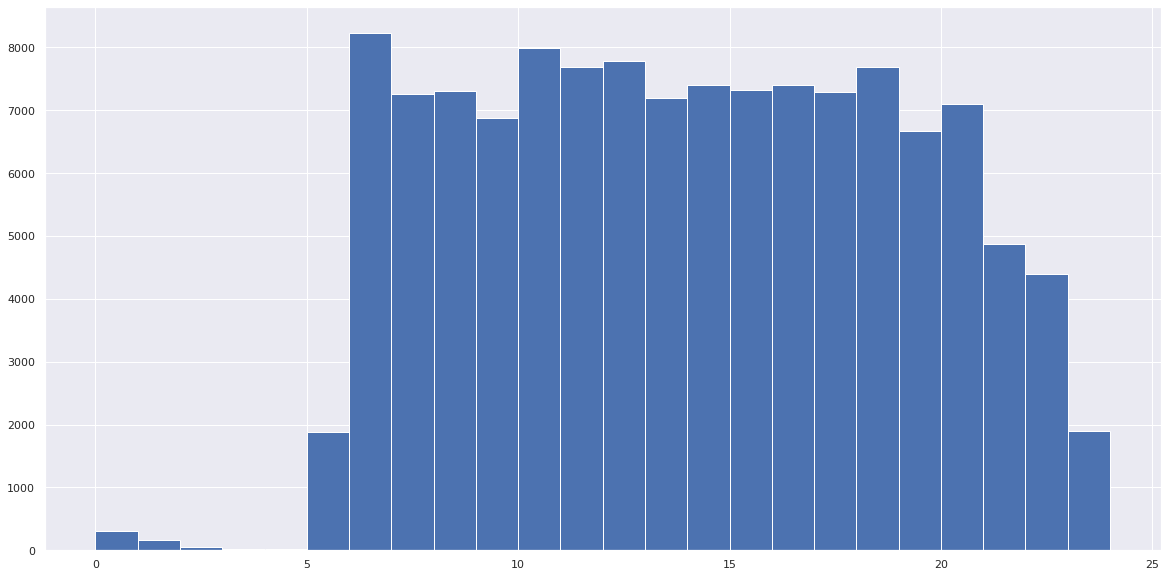

In [120]:
plt.figure(figsize=(20,10))
plt.hist(sort_flight_hours, bins = 24)
plt.show()

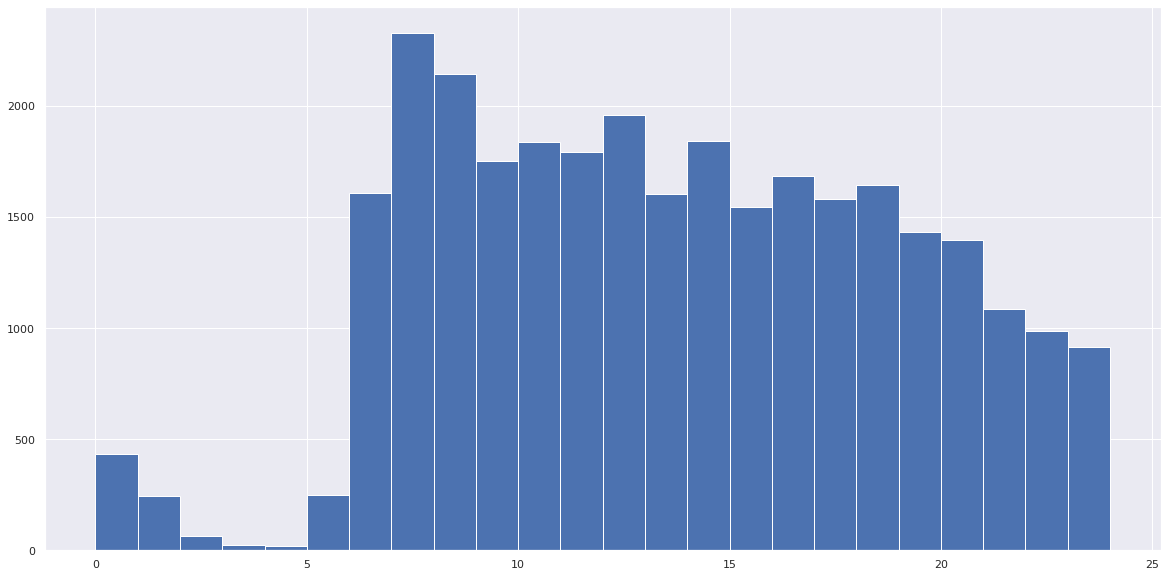

In [121]:
plt.figure(figsize=(20,10))
plt.hist(medium_flight_hours, bins = 24)
plt.show()

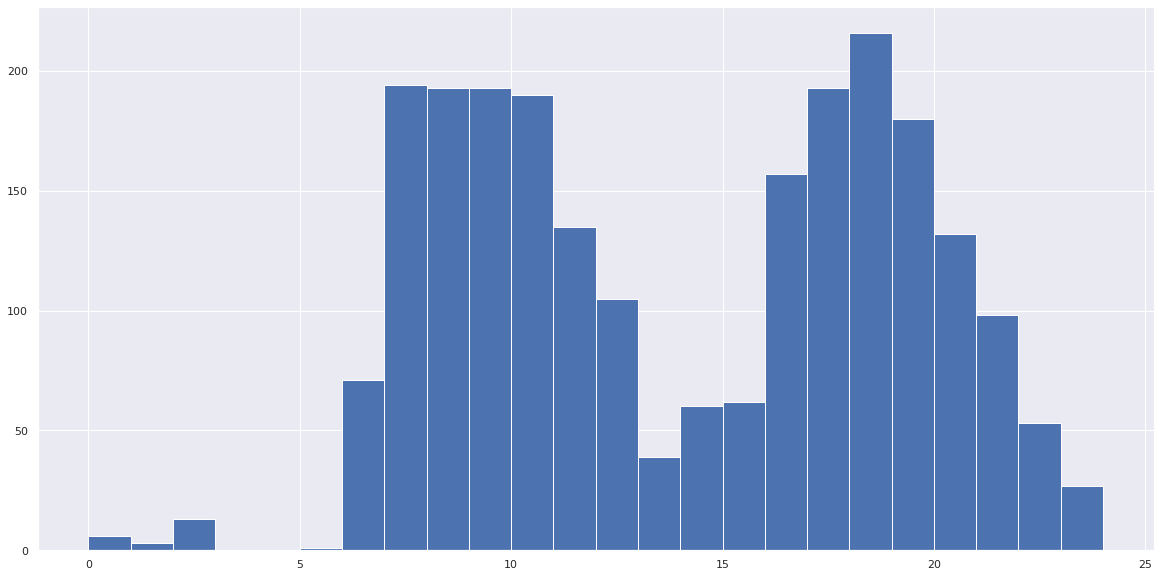

In [122]:
plt.figure(figsize=(20,10))
plt.hist(long_flight_hours, bins = 24)
plt.show()

In [123]:
sort_flight_hours.mode()

0    6.0
dtype: float64

In [124]:
medium_flight_hours.mode()

0    7.0
dtype: float64

In [125]:
long_flight_hours.mode()

0    18.0
dtype: float64

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [126]:
total_flights_by_airport = inbound_traffic + outbound_traffic

In [127]:
total_flights_by_airport.sort_values(by='flights', ascending=False).head(10)

,flights
ORD,15951.0
ATL,15813.0
DFW,11599.0
DEN,11307.0
CLT,9981.0
LAX,9972.0
SEA,7557.0
PHX,7277.0
IAH,7248.0
SFO,7187.0


In [128]:
passengers = pd.read_csv('data/passengers_10%.csv')

In [129]:
passengers.columns

Index(['departures_scheduled', 'departures_performed', 'payload', 'seats',
       'passengers', 'freight', 'mail', 'distance', 'ramp_to_ramp', 'air_time',
       'unique_carrier', 'airline_id', 'unique_carrier_name', 'region',
       'carrier', 'carrier_name', 'carrier_group', 'carrier_group_new',
       'origin_airport_id', 'origin_city_market_id', 'origin',
       'origin_city_name', 'origin_country', 'origin_country_name',
       'dest_airport_id', 'dest_city_market_id', 'dest', 'dest_city_name',
       'dest_country', 'dest_country_name', 'aircraft_group', 'aircraft_type',
       'aircraft_config', 'year', 'month', 'distance_group', 'class',
       'data_source'],
      dtype='object')

In [130]:
passengers_outbound = passengers.groupby('origin').passengers.sum().to_frame()
passengers_inbound = passengers.groupby('dest').passengers.sum().to_frame()

In [131]:
total_passengers_by_airport = passengers_inbound + passengers_outbound

In [132]:
total_passengers_by_airport.sort_values(by='passengers', ascending=False).head(10)

,passengers
ATL,51818383.0
LAX,41097981.0
ORD,39440105.0
DFW,33407741.0
DEN,30880909.0
JFK,29857711.0
SFO,26376070.0
LAS,23342225.0
CLT,22295158.0
MCO,21987855.0


#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [133]:
flights_1_copy4 = flights_1.copy()
fuel_consumption_copy = fuel_consumption.copy()
passengers_10_copy = passengers_10.copy()

In [134]:
flights_1_copy4['month']=flights_1_copy4.fl_date
flights_1_copy4.month = flights_1_copy4.month.map(lambda v: int(v[5:7]))

### First Point
Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)

In [135]:
flights_1_op_unique_carrier = list(flights_1_copy4.op_unique_carrier.unique())

In [136]:
flights_1_copy4_1 = flights_1_copy4.dropna(subset=['arr_delay'])

In [137]:
ave_mon_delay_per_air_car = flights_1_copy4_1.groupby(['op_unique_carrier','month']).arr_delay.mean().groupby('op_unique_carrier').mean()
ave_mon_delay_per_air_car = ave_mon_delay_per_air_car.sort_values()



<BarContainer object of 28 artists>

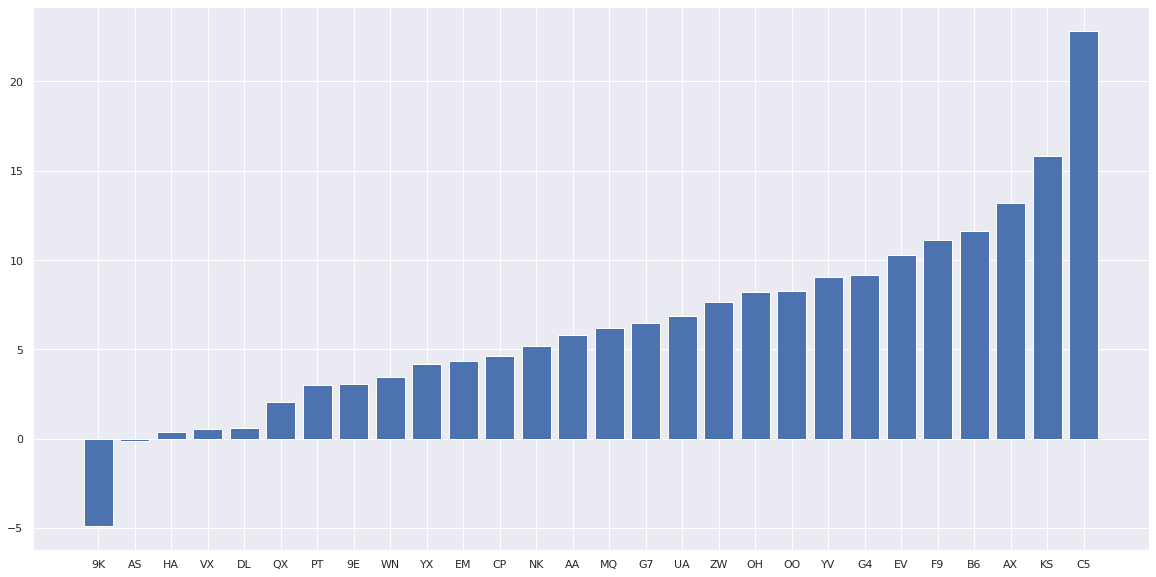

In [138]:
plt.figure(figsize=(20,10))
plt.bar(ave_mon_delay_per_air_car.keys(), ave_mon_delay_per_air_car)

### Second Point
Find out distance covered monthly by different air carriers

In [139]:
monthly_dist_per_air_car = flights_1_copy4.groupby(['op_unique_carrier','month']).distance.sum().groupby('op_unique_carrier').mean()
monthly_dist_per_air_car = monthly_dist_per_air_car.sort_values()



<BarContainer object of 28 artists>

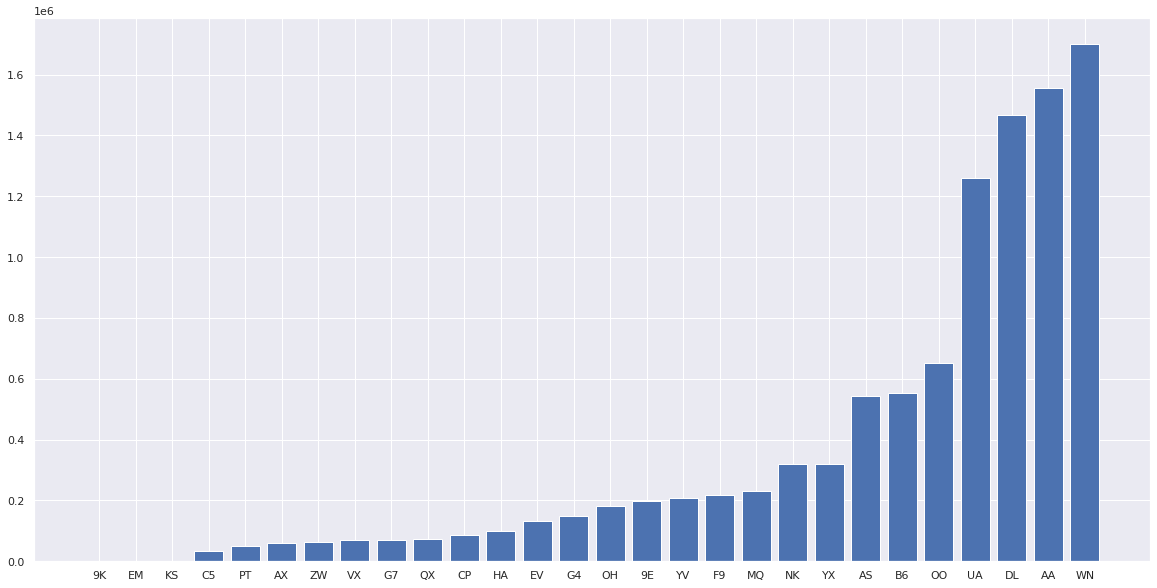

In [140]:
plt.figure(figsize=(20,10))
plt.bar(monthly_dist_per_air_car.keys(), monthly_dist_per_air_car)

### Third Point
Find out number of passengers that were carried by different air carriers

In [141]:
passengers_10_unique_carrier = passengers_10_copy[passengers_10_copy.unique_carrier.isin(flights_1_op_unique_carrier)]
passengers_10_unique_carrier = passengers_10_unique_carrier.groupby('unique_carrier').passengers.sum().sort_values()


<BarContainer object of 28 artists>

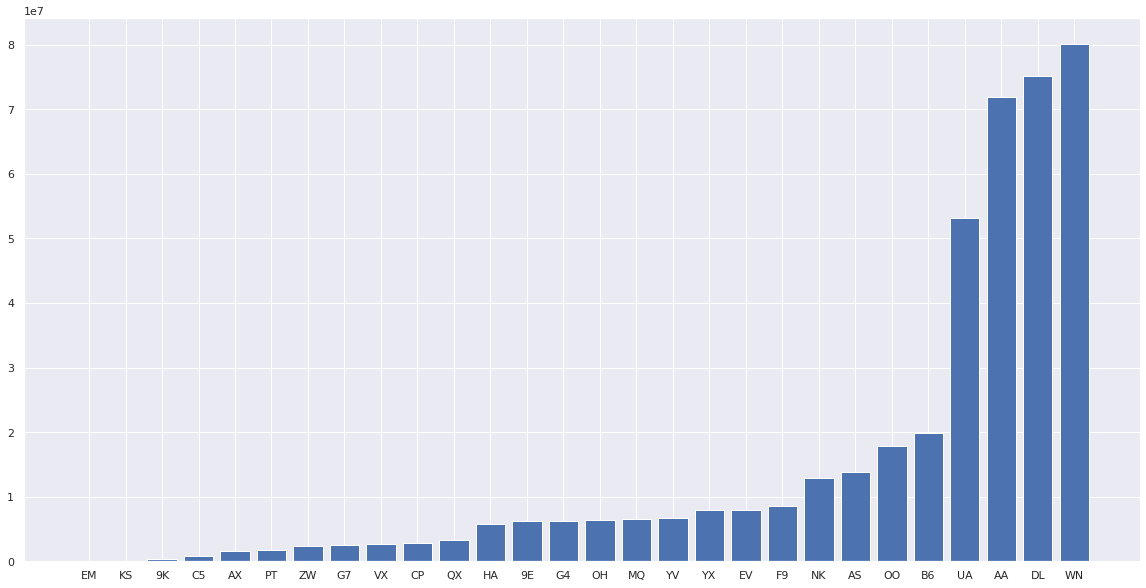

In [142]:
plt.figure(figsize=(20,10))
plt.bar(passengers_10_unique_carrier.keys(), passengers_10_unique_carrier)

### Fourth Point
Find out total fuel comsumption per air carrier.

In [143]:
fuel_consumption_unique_carrier = fuel_consumption_copy[fuel_consumption_copy.unique_carrier.isin(flights_1_op_unique_carrier)]
fuel_consumption_unique_carrier = fuel_consumption_unique_carrier.groupby('unique_carrier').total_gallons.sum().sort_values()


<BarContainer object of 22 artists>

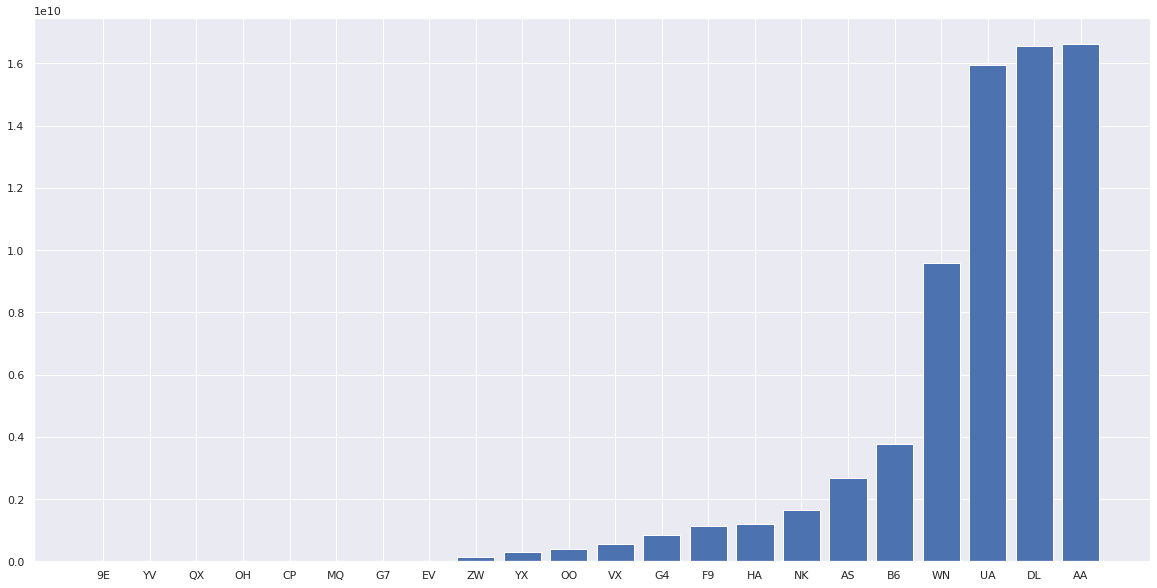

In [144]:
plt.figure(figsize=(20,10))
plt.bar(fuel_consumption_unique_carrier.keys(), fuel_consumption_unique_carrier)